In [1]:
import os
import json
import glob
import cv2

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import SAM
from huggingface_hub import snapshot_download
ROOT_DIR = "/home/data/pace"

/home/dhoban/RIPS25-AnalogDevices-ObjectDetection/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
## Download PACE Dataset folders

# repo_id = "qq456cvb/PACE"  # Replace with the actual dataset ID
# local_dir = "."  # The local path where you want to save the folder
# allow_patterns = ["model_splits/*"] # To download a specific folder within the dataset
# snapshot_download(repo_id=repo_id, local_dir=local_dir, allow_patterns=allow_patterns, repo_type="dataset")

# len(glob.glob(f'{ROOT_DIR}/test/*')), len(glob.glob(f'{ROOT_DIR}/val_inst/*')) ###, len(glob.glob(f'{ROOT_DIR}/val_pbr_cat/*'))

In [3]:
# Create list of all object classes
all_categories = ['_'.join(x.split('/')[-1].split('_')[:-1]) for x in glob.glob(f'{ROOT_DIR}/model_splits/category/*_train.txt')]
all_categories.sort()
print(f"Total number of unique categories: {len(all_categories)}")

# Compile the data dictionary: data[video_id][frame_id] = set of all instance IDs in that frame of that video
data = dict()

for video_path in glob.glob(f'{ROOT_DIR}/test/*')+glob.glob(f'{ROOT_DIR}/val_inst/*'):
	video_id = int(video_path.split('/')[-1])
	frame_ids = [int(f.split('/')[-1].split('.')[0]) for f in glob.glob(f'{video_path}/rgb/*')]
	data[video_id] = {frame_id: set() for frame_id in frame_ids}
	
	with open(f'{video_path}/scene_gt_coco_det_modal_inst.json', 'r') as f:
		video_json = json.load(f)

	for anno in video_json['annotations']:
		object_instance_id = anno['category_id']
		frame_id = anno['image_id']
		data[video_id][frame_id].add(object_instance_id)

# Create dictionary to fetch all instance IDs for a given category
instances_of_category = dict()
category_of_instance = dict()
for category in all_categories:
	test_instance_ids = [int(x.split('_')[-1]) for x in open(f'{ROOT_DIR}/model_splits/category/{category}_test.txt', 'r').read().splitlines()]
	val_instance_ids = [int(x.split('_')[-1]) for x in open(f'{ROOT_DIR}/model_splits/category/{category}_val.txt', 'r').read().splitlines()]
	instances_of_category[category] = set(test_instance_ids + val_instance_ids)
	
	for instance in instances_of_category[category]:
		category_of_instance[instance] = category

	print(f'Category {category}, has {len(instances_of_category[category])} instances: {instances_of_category[category]}')


# Create set of all instance IDs
all_instances = set()
for cat in instances_of_category:
	all_instances.update(instances_of_category[cat])
print(f'Total number of unique instances: {len(all_instances)}')

Total number of unique categories: 47
Category bottle, has 16 instances: {705, 2, 3, 4, 5, 6, 11, 14, 15, 16, 18, 20, 21, 694, 24, 700}
Category bowl, has 12 instances: {739, 36, 38, 40, 42, 43, 720, 722, 30, 728, 734, 735}
Category box-base_link, has 10 instances: {608, 579, 548, 554, 558, 591, 593, 595, 603, 572}
Category box-link1, has 10 instances: {578, 547, 553, 557, 590, 592, 594, 602, 571, 607}
Category brush, has 7 instances: {48, 49, 50, 51, 53, 55, 56}
Category can, has 17 instances: {66, 70, 71, 72, 73, 74, 778, 766, 761, 758, 57, 58, 59, 764, 61, 62, 63}
Category chip_can, has 8 instances: {75, 76, 77, 78, 79, 81, 82, 789}
Category clip-link1, has 4 instances: {632, 610, 628, 618}
Category clip-link2, has 4 instances: {609, 627, 617, 631}
Category clock, has 9 instances: {808, 792, 93, 85, 87, 88, 89, 90, 797}
Category container, has 7 instances: {96, 97, 815, 823, 825, 829, 95}
Category cutter-base_link, has 5 instances: {642, 646, 650, 636, 638}
Category cutter-link1, ha

# Instance & video train-val-test split

In [4]:
output_dir = f'{ROOT_DIR}/pace_v3'
target_categories = ['toy_car', 'can', 'snack_box', 'ramen_box']

In [5]:
def isInstanceInVideo(instance_id, video_id):
	"""Check if a given instance ID is present in any frame of the specified video."""
	return any(instance_id in frame_instances for frame_instances in data[video_id].values())

def set_union(sets):
    return set().union(*sets)

def sets_are_disjoint(sets):
	"""Check if all sets in the list are disjoint."""
	combined = set()
	for s in sets:
		if not combined.isdisjoint(s):
			return False
		combined.update(s)
	return True

def existInSameVideo(instance1, instance2):
    for video_id in data:
        if isInstanceInVideo(instance1, video_id) and isInstanceInVideo(instance2, video_id):
            return True
    return False

In [6]:
import networkx as nx
from itertools import combinations

/tmp/ipykernel_532003/250402190.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


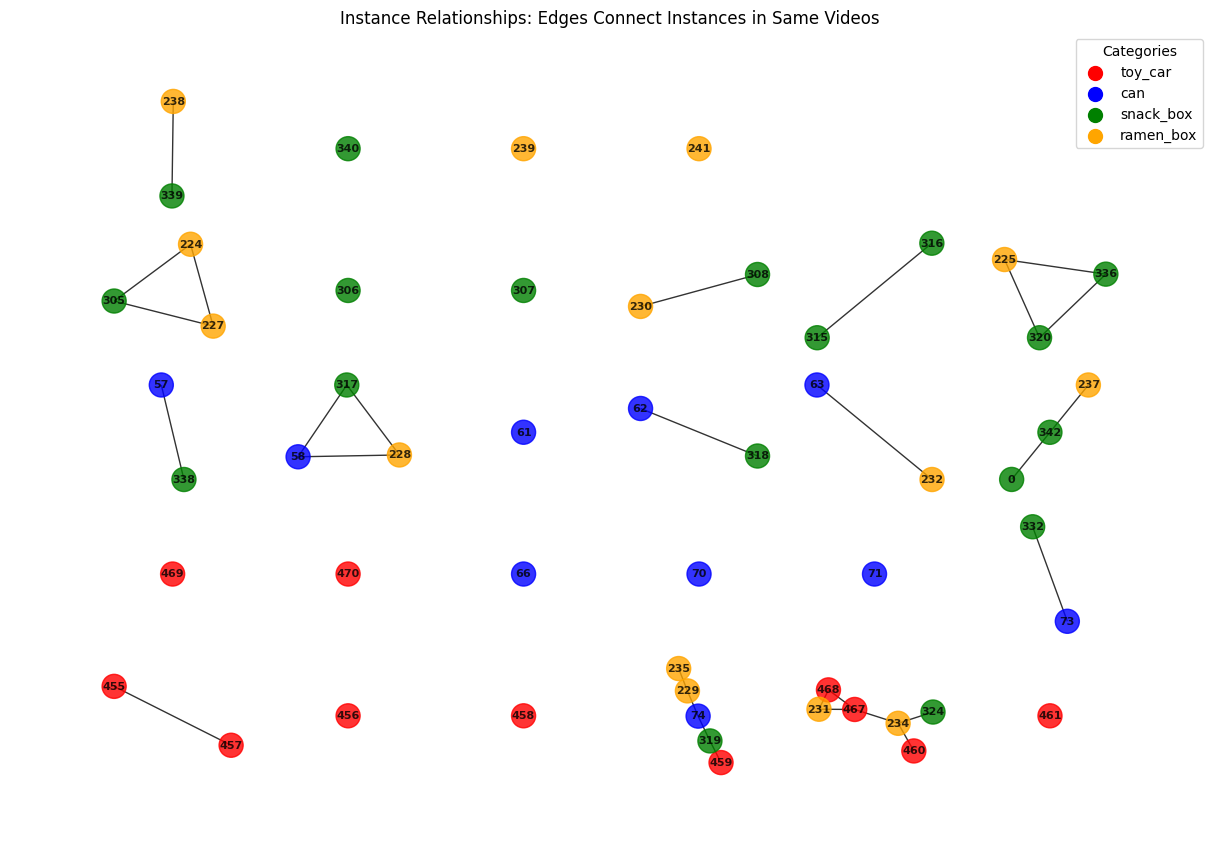

Graph has 53 nodes and 29 edges
Connected components: 28
Component 1: 2 instances - [455, 457]
Component 2: 1 instances - [456]
Component 3: 1 instances - [458]
Component 4: 5 instances - [74, 229, 235, 319, 459]
Component 5: 6 instances - [231, 234, 324, 460, 467, 468]
Component 6: 1 instances - [461]
Component 7: 1 instances - [469]
Component 8: 1 instances - [470]
Component 9: 1 instances - [66]
Component 10: 1 instances - [70]
Component 11: 1 instances - [71]
Component 12: 2 instances - [73, 332]
Component 13: 2 instances - [57, 338]
Component 14: 3 instances - [58, 228, 317]
Component 15: 1 instances - [61]
Component 16: 2 instances - [62, 318]
Component 17: 2 instances - [63, 232]
Component 18: 3 instances - [0, 237, 342]
Component 19: 3 instances - [224, 227, 305]
Component 20: 1 instances - [306]
Component 21: 1 instances - [307]
Component 22: 2 instances - [230, 308]
Component 23: 2 instances - [315, 316]
Component 24: 3 instances - [225, 320, 336]
Component 25: 2 instances - 

In [7]:
# Create a graph to visualize instance relationships
G = nx.Graph()

# Add all target category instances as nodes
target_instances = set()
for category in target_categories:
	for instance in instances_of_category[category]:
		if any(isInstanceInVideo(instance, videoID) for videoID in data.keys()):
			target_instances.add(instance)
			G.add_node(instance, category=category)

# Add edges between instances that appear in the same video
for instance1, instance2 in combinations(target_instances, 2):
	if existInSameVideo(instance1, instance2):
		G.add_edge(instance1, instance2)

# Create visualization
plt.figure(figsize=(12, 8))

# Create color map for different categories
category_colors = {
	'toy_car': 'red',
	'can': 'blue', 
	'snack_box': 'green',
	'ramen_box': 'orange'
}

# Get node colors based on category
node_colors = [category_colors[G.nodes[node]['category']] for node in G.nodes()]

# Calculate positions for each connected component separately
pos = {}
components = list(nx.connected_components(G))
n_components = len(components)

# Arrange components in a grid-like pattern
import math
grid_size = math.ceil(math.sqrt(n_components))

for i, component in enumerate(components):
	# Create subgraph for this component
	subgraph = G.subgraph(component)
	
	# Calculate grid position for this component
	row = i // grid_size
	col = i % grid_size
	
	# Get layout for this component
	if len(component) > 1:
		# Use spring layout for connected components
		sub_pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
	else:
		# Single node component
		sub_pos = {list(component)[0]: (0, 0)}
	
	# Offset positions to separate components
	offset_x = col * 3.0  # Horizontal separation
	offset_y = row * 3.0  # Vertical separation
	
	for node, (x, y) in sub_pos.items():
		pos[node] = (x + offset_x, y + offset_y)

# Draw the graph
nx.draw(G, pos, 
		node_color=node_colors,
		node_size=300,
		with_labels=True,
		font_size=8,
		font_weight='bold',
		alpha=0.8)

# Create legend
legend_elements = [plt.scatter([], [], c=color, s=100, label=category) 
				  for category, color in category_colors.items()]
plt.legend(handles=legend_elements, title='Categories')

plt.title('Instance Relationships: Edges Connect Instances in Same Videos')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print graph statistics
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Connected components: {nx.number_connected_components(G)}")

# Print component information
for i, component in enumerate(nx.connected_components(G)):
	print(f"Component {i+1}: {len(component)} instances - {sorted(list(component))}")

In [8]:
# Find optimal split of components into train/val/test to balance total frames
def get_component_frame_counts(components):
	"""Calculate total frames for each component"""
	component_frame_counts = []
	for component in components:
		total_frames = 0
		for video_id in data.keys():
			if any(isInstanceInVideo(instance, video_id) for instance in component):
				total_frames += len(data[video_id]) ### ASSUMING the instance appears in all frames of a video if it appears in any
		component_frame_counts.append(total_frames)
	return component_frame_counts

def balance_split_components(components, frame_counts, target_ratio=(0.6, 0.2, 0.2)):
	"""Split components into train/val/test to balance total frames"""
	total_frames = sum(frame_counts)
	target_train = total_frames * target_ratio[0]
	target_val = total_frames * target_ratio[1] 
	target_test = total_frames * target_ratio[2]
	
	# Sort components by frame count (largest first for greedy assignment)
	sorted_indices = sorted(range(len(components)), key=lambda i: frame_counts[i], reverse=True)
	
	splits = {'train': [], 'val': [], 'test': []}
	split_totals = {'train': 0, 'val': 0, 'test': 0}
	
	# Greedy assignment: assign each component to the split that needs it most
	for idx in sorted_indices:
		component = components[idx]
		frames = frame_counts[idx]
		
		# Calculate how far each split is from its target
		train_deficit = target_train - split_totals['train']
		val_deficit = target_val - split_totals['val']
		test_deficit = target_test - split_totals['test']
		
		# Assign to the split with the largest deficit
		if train_deficit >= val_deficit and train_deficit >= test_deficit:
			splits['train'].append(component)
			split_totals['train'] += frames
		elif val_deficit >= test_deficit:
			splits['val'].append(component)
			split_totals['val'] += frames
		else:
			splits['test'].append(component)
			split_totals['test'] += frames
	
	return splits, split_totals

# Get components and their frame counts
components = list(nx.connected_components(G))
component_frame_counts = get_component_frame_counts(components)

# Balance the split
component_splits, split_totals = balance_split_components(components, component_frame_counts, target_ratio=(0.4,0.2,0.4))

all_instances_per_split = {'train': set(), 'val': set(), 'test': set()}
for split_name in ['train', 'val', 'test']:
	for component in component_splits[split_name]:
		all_instances_per_split[split_name].update(component)

# Print results
total_all_frames = sum(split_totals.values())
print(f"Total frames across all components: {total_all_frames}")
print(f"\nBalanced component splits:")
for split_name in ['train', 'val', 'test']:
	num_components = len(component_splits[split_name])
	total_frames = split_totals[split_name]
	percentage = (total_frames / total_all_frames) * 100
	print(f"{split_name:>5}: {num_components:2d} components, {total_frames:4d} frames ({percentage:5.1f}%)")
	
	# Show which instances are in each split
	print(f"       {len(all_instances_per_split[split_name])} Instances: {sorted(list(all_instances_per_split[split_name]))}")

Total frames across all components: 33030

Balanced component splits:
train: 10 components, 13131 frames ( 39.8%)
       22 Instances: [63, 73, 225, 230, 231, 232, 234, 238, 241, 306, 308, 320, 324, 332, 336, 339, 455, 457, 460, 467, 468, 469]
  val:  8 components, 6543 frames ( 19.8%)
       12 Instances: [58, 61, 62, 228, 239, 307, 315, 316, 317, 318, 340, 458]
 test: 10 components, 13356 frames ( 40.4%)
       19 Instances: [0, 57, 66, 70, 71, 74, 224, 227, 229, 235, 237, 305, 319, 338, 342, 456, 459, 461, 470]


In [9]:
instance_splits = {'train': defaultdict(set), 'val': defaultdict(set), 'test': defaultdict(set)}

## FOR EACH OF THE CHOSEN VIDEOS
# for category in target_categories:
# 	instance_splits[category]

for split_name in ['train', 'val', 'test']:
	# Show which instances are in each split
	for instance in all_instances_per_split[split_name]:
		class_name = category_of_instance[instance]
		instance_splits[split_name][class_name].add(instance)

In [11]:
instance_splits

{'train': defaultdict(set,
             {'snack_box': {306, 308, 320, 324, 332, 336, 339},
              'toy_car': {455, 457, 460, 467, 468, 469},
              'can': {63, 73},
              'ramen_box': {225, 230, 231, 232, 234, 238, 241}}),
 'val': defaultdict(set,
             {'snack_box': {307, 315, 316, 317, 318, 340},
              'ramen_box': {228, 239},
              'toy_car': {458},
              'can': {58, 61, 62}}),
 'test': defaultdict(set,
             {'snack_box': {0, 305, 319, 338, 342},
              'can': {57, 66, 70, 71, 74},
              'toy_car': {456, 459, 461, 470},
              'ramen_box': {224, 227, 229, 235, 237}})}

In [ ]:
# video_splits = {'train': dict(), 'val': dict(), 'test': dict()}
# instance_splits = {'train': dict(), 'val': dict(), 'test': dict()}
# distractor_splits = {'train': dict(), 'val': dict(), 'test': dict()}

# instance_splits['train']['toy_car'] = {456, 458, 461, 470}
# instance_splits['val']['toy_car'] = {459, 460, 467, 468}
# instance_splits['test']['toy_car'] = {455, 457, 469}

# instance_splits['train']['can'] = {74, 57, 58}
# instance_splits['val']['can'] = {66, 70, 71, 73}
# instance_splits['test']['can'] = {61, 62, 63}

# instance_splits['train']['distractor'] = {320, 324, 336, 340,    2, 16,    437, 448}
# instance_splits['val']['distractor'] = {315, 316, 317, 318,    5, 6,    434, 435}
# instance_splits['test']['distractor'] = {305, 306, 307, 308,    21, 24,   451, 436}

In [12]:
video_splits = {'train': defaultdict(set), 'val': defaultdict(set), 'test': defaultdict(set)}

# Given the instance splits, construct video splits (all videos containing train instances become train videos, etc.)
already_assigned_videos = set()
for split in instance_splits:
    for video_id, frames in data.items():
        for instance in all_instances_per_split[split]:
            if isInstanceInVideo(instance, video_id):
                video_splits[split][category].add(video_id)

In [13]:
video_splits

{'train': defaultdict(set,
             {'ramen_box': {9,
               10,
               11,
               12,
               13,
               14,
               21,
               22,
               23,
               27,
               28,
               29,
               39,
               40,
               41,
               42,
               43,
               44,
               66,
               67,
               68,
               78,
               79,
               80,
               96,
               97,
               98,
               123,
               124,
               125,
               138,
               139,
               140,
               144,
               145,
               146,
               153,
               154,
               155,
               159,
               160,
               161,
               174,
               175,
               176,
               195,
               196,
               197,
               204,
        

In [14]:
# video_splits = {'train': dict(), 'val': dict(), 'test': dict()}

# # Given the instance splits, construct video splits (all videos containing train instances become train videos, etc.)
# already_assigned_videos = set()
# for split in instance_splits:
# 	for category in instance_splits[split]:
# 		video_splits[split][category] = set()
# 		for instance in instance_splits[split][category]:
# 			# add each video that contains this instance to the split
# 			for video_id, frames in data.items():
# 				if isInstanceInVideo(instance, video_id):
# 					# if the video is already assigned to another category, this may create a conflict
# 					if (video_id in already_assigned_videos) and (video_id not in video_splits[split][category]):
# 						if category == 'distractor':
# 							continue  # Just don't add the distractor videos that would create conflict
# 						raise ValueError(f"Splits are not disjoint! {video_id} is in both {video_splits[split][category]}")

# 					video_splits[split][category].add(video_id)
# 					already_assigned_videos.add(video_id)

for split in video_splits:
	for category in video_splits[split]:
		print(f'{split:>5} | {category:>7} | Videos:    {sorted(list(video_splits[split][category]))}')
		if len(video_splits[split][category]) == 0:
			print(f'Warning: No videos found for split {split} and category {category}.')

for split in video_splits:
	for category in video_splits[split]:
		print(f'{split:>5} | {category:>7} | Instances: {sorted(list(instance_splits[split][category]))}')
		if len(instance_splits[split][category]) == 0:
			print(f'Warning: No instances found for split {split} and category {category}.')

videos_in_data_split = {'train': set(), 'val': set(), 'test': set()} # set of video IDs for each data split
instances_in_data_split = {'train': set(), 'val': set(), 'test': set()} # set of TARGET instance IDs for each data split
for split in video_splits:
	videos_in_data_split[split] = set_union(video_splits[split][category] for category in video_splits[split])
	instances_in_data_split[split] = set_union(instance_splits[split][category] for category in instance_splits[split] if category!='distractor')

videos_in_category = {category:set() for category in video_splits['train']} # set of video IDs for each category
instances_in_category = {category:set() for category in instance_splits['train']} # set of instance IDs for each category
for category in video_splits[split]:
	videos_in_category[category] = videos_in_category[category].union(video_splits[split][category])
	instances_in_category[category] = instances_in_category[category].union(instance_splits[split][category])

assert sets_are_disjoint([videos_in_data_split['train'], videos_in_data_split['test'], videos_in_data_split['val']])
assert sets_are_disjoint([instances_in_data_split['train'], instances_in_data_split['val'], instances_in_data_split['test']])

print(f'Train videos: {len(videos_in_data_split["train"])}, Train instances: {len(instances_in_data_split["train"])}')
print(f'Val videos: {len(videos_in_data_split["val"])}, Val instances: {len(instances_in_data_split["val"])}')
print(f'Test videos: {len(videos_in_data_split["test"])}, Test instances: {len(instances_in_data_split["test"])}')

train | ramen_box | Videos:    [9, 10, 11, 12, 13, 14, 21, 22, 23, 27, 28, 29, 39, 40, 41, 42, 43, 44, 66, 67, 68, 78, 79, 80, 96, 97, 98, 123, 124, 125, 138, 139, 140, 144, 145, 146, 153, 154, 155, 159, 160, 161, 174, 175, 176, 195, 196, 197, 204, 205, 206, 225, 226, 227, 228, 229, 230, 246, 247, 248, 249, 250, 251, 270, 271, 272, 279, 280, 281, 282, 283, 284]
  val | ramen_box | Videos:    [3, 4, 5, 18, 19, 20, 24, 25, 26, 30, 31, 32, 33, 34, 35, 57, 58, 59, 63, 64, 65, 102, 103, 104, 180, 181, 182, 192, 193, 194, 213, 214, 215, 219, 220, 221]
 test | ramen_box | Videos:    [0, 1, 2, 6, 7, 8, 15, 16, 17, 36, 37, 38, 45, 46, 47, 48, 49, 50, 51, 52, 53, 60, 61, 62, 72, 73, 74, 90, 91, 92, 93, 94, 95, 120, 121, 122, 126, 127, 128, 141, 142, 143, 168, 169, 170, 171, 172, 173, 177, 178, 179, 183, 184, 185, 186, 187, 188, 216, 217, 218, 222, 223, 224, 261, 262, 263, 264, 265, 266, 288, 289, 290, 291, 292, 293]
train | ramen_box | Instances: [225, 230, 231, 232, 234, 238, 241]
  val | ramen

In [15]:
## create a dictionary where the key is an instance ID, and the value is a list of video IDs where it appears
videos_containing_instance = defaultdict(set)
for video_id in data.keys():
	for instance in all_instances:
		if isInstanceInVideo(instance, video_id):
			videos_containing_instance[instance].add(video_id)

In [16]:
# find distractor instances that appear in the train videos but not in the val or test videos
train_instances = set()
# for video_id in videos_in_data_split['train']:
for instance_id in videos_containing_instance.keys():  # Check the first frame of the video
	# if any(video_id in videos_in_data_split['train'] for video_id in videos_containing_instance[instance_id]) and \

	if any(video_id in videos_in_data_split['train'] for video_id in videos_containing_instance[instance_id]) and \
	   not any(video_id in videos_in_data_split['val'] for video_id in videos_containing_instance[instance_id]) and \
	   not any(video_id in videos_in_data_split['test'] for video_id in videos_containing_instance[instance_id]):
		train_instances.add(instance_id)

target_train_instances = set_union([instance_splits['train'][category] for category in target_categories])
distractor_instances = train_instances.difference(target_train_instances)
print(f'{len(distractor_instances)} distractor instances: {sorted(list(distractor_instances))}')

41 distractor instances: [5, 6, 21, 24, 38, 50, 55, 93, 97, 114, 115, 117, 122, 127, 151, 163, 194, 202, 206, 208, 254, 392, 396, 397, 399, 426, 428, 429, 430, 449, 474, 519, 531, 592, 593, 617, 618, 637, 638, 667, 668]


In [17]:
def convert_bbox_to_yolo(bbox, img_width, img_height):
    """
    Convert bounding box from [x, y, width, height] format to YOLO format
    [x_center, y_center, width, height] normalized by image dimensions
    """
    x, y, w, h = bbox
    x_center = (x + w/2) / img_width
    y_center = (y + h/2) / img_height
    norm_width = w / img_width
    norm_height = h / img_height
    return x_center, y_center, norm_width, norm_height

def process_annotation_file(json_file_path):
    """
    Process a video annotation file and convert to YOLO format
    Returns a dictionary mapping frame_id to list of YOLO format annotations
    """
    with open(json_file_path, 'r') as f:
        annotations = json.load(f)['annotations']
    
    frame_annotations = defaultdict(list)
    
    for anno in annotations:
        # if anno.get('ignore', False):  # Skip ignored annotations
        #     print(f"Skipping ignored annotation: {anno}")
        #     if anno['category_id'] in wallet_instances.union(can_instances):
        #         print('can or wallet skipped')
        #     continue
            
        frame_id = anno['image_id']
        class_id = anno['category_id']
        bbox = anno['bbox']  # [x, y, width, height]
        img_width = anno['width']
        img_height = anno['height']
        
        # Convert to YOLO format
        x_center, y_center, norm_width, norm_height = convert_bbox_to_yolo(bbox, img_width, img_height)
        
        yolo_annotation = {
            'class_id': class_id,
            'x_center': x_center,
            'y_center': y_center,
            'width': norm_width,
            'height': norm_height
        }
        
        frame_annotations[frame_id].append(yolo_annotation)
    
    return frame_annotations

In [ ]:
# toy_car : 0
# can : 1
category_to_label = {category: i for i, category in enumerate(target_categories)}
label_to_category_name = {x: category for category, x in category_to_label.items()} # maps class numbers (from  darknet labels) to category/class names

In [20]:
category_to_label

{'toy_car': 0, 'can': 1, 'snack_box': 2, 'ramen_box': 3}

# Dataset Processing

In [26]:
def get_category_name(instance_id):
	category_name_search = [cat for cat in instances_of_category if instance_id in instances_of_category[cat]]
	assert len(category_name_search) >= 0, f"No categories found for label {instance_id}"
	assert len(category_name_search) == 1, f"Multiple categories found for label {instance_id}"
	return category_name_search[0]

In [27]:
# Create train, val, test splits
for split in ['train', 'val', 'test']:
	if not os.path.exists(f'{output_dir}/{split}/images/'):
		os.makedirs(f'{output_dir}/{split}/images/')
	if not os.path.exists(f'{output_dir}/{split}/labels/'):
		os.makedirs(f'{output_dir}/{split}/labels/')
	if not os.path.exists(f'{output_dir}-extra/{split}/full_labels/'):
		os.makedirs(f'{output_dir}-extra/{split}/full_labels/')

for video_path in glob.glob(f'{ROOT_DIR}/test/*')+glob.glob(f'{ROOT_DIR}/val_inst/*'):
	video_id = int(video_path.split('/')[-1])
	if video_id in videos_in_data_split['train']:
		split = 'train'
	elif video_id in videos_in_data_split['val']:
		split = 'val'
	elif video_id in videos_in_data_split['test']:
		split = 'test'
	else:
		continue

	labels = process_annotation_file(f'{video_path}/scene_gt_coco_det_modal_inst.json')
	for frame_id in glob.glob(f'{video_path}/rgb/*'):
		# print(f"cp {frame_id} {ROOT_DIR}/wallet_can_v0/{split}/{str(video_id)}/{video_id}_{os.path.basename(frame_id)}")
		os.system(f"cp {frame_id} {output_dir}/{split}/images/{str(video_id)}_{int(os.path.basename(frame_id).split('.')[0])}.png")

		frame_num = int(os.path.basename(frame_id).split('.')[0])
		full_label_path = f"{output_dir}-extra/{split}/full_labels/{str(video_id)}_{frame_num}.txt"
		label_path = f"{output_dir}/{split}/labels/{str(video_id)}_{frame_num}.txt"

		for label in labels[frame_num]:
			category_name = get_category_name(label['class_id'])
			
			if category_name in target_categories:
				category_id = category_to_label[category_name]
				# if the category is one of the chosen categories, write to the label file
				with open(label_path, 'a') as f:
					f.write(f"{category_id} {label['x_center']} {label['y_center']} {label['width']} {label['height']}\n")
			
			# write to the full label file regardless of category
			### NOTE: store instance IDs here instead of class IDs
			with open(full_label_path, 'a') as f:
				f.write(f"{label['class_id']} {label['x_center']} {label['y_center']} {label['width']} {label['height']}\n")

sh: 0: getcwd() failed: No such file or directory
cp: cannot create regular file '/home/data/pace/pace_v3/train/images/249_4.png': Permission denied


PermissionError: [Errno 13] Permission denied: '/home/data/pace/pace_v3/train/labels/249_4.txt'

In [ ]:
for split in ['train', 'val', 'test']:
    for image_path in glob.glob(f'{output_dir}/{split}/images/*'):
        label_path = image_path.replace('.png', '.txt').replace('/images', '/labels')
        full_label_path = image_path.replace(f'{output_dir}/', f'{output_dir}-extra/').replace('.png', '.txt').replace('/images', '/full_labels')
        if not os.path.exists(label_path):
            os.system(f"touch {label_path}")
        if not os.path.exists(full_label_path):
            os.system(f"touch {full_label_path}")

In [ ]:
for split in ['train', 'val', 'test']:
	path = f"{output_dir}/{split}"
	for image_path in glob.glob(f'{path}/images/*'):
		if not os.path.exists(image_path.replace('.png', '.txt').replace('/images', '/labels')):
			print(f"Missing label for image: {image_path}")

# for label_path in glob.glob(f'{path}/labels/*'):
# 	if not os.path.exists(label_path.replace('.txt', '.png').replace('/labels', '/images')):
# 		print(f"Missing image for label file: {label_path}")

In [28]:
# print number of images and labels in each split
for split in ['train', 'val', 'test']:
	num_images = len(glob.glob(f'{output_dir}/{split}/images/*'))
	num_labels = len(glob.glob(f'{output_dir}/{split}/labels/*'))
	num_full_labels = len(glob.glob(f'{output_dir}-extra/{split}/full_labels/*'))
	print(f"{split.capitalize()} - Images: {num_images}, Labels: {num_labels}, Full Labels: {num_full_labels}")

Train - Images: 11498, Labels: 11322, Full Labels: 11495
Val - Images: 5547, Labels: 5441, Full Labels: 5547
Test - Images: 10825, Labels: 10822, Full Labels: 10825


# Segment to get foreground object images

In [29]:
def read_darknet_bboxes(bbox_path, image_width, image_height):
	"""Read bounding boxes from darknet format file and convert to pixel coordinates"""
	bboxes = []
	
	with open(bbox_path, 'r') as f:
		foundLine = False
		class_ids = []
		for line in f:
			foundLine = True
			parts = line.strip().split()
			assert len(parts) == 5, f"Invalid bbox line: {line.strip()}"
			
			# Darknet format: class_id x_center y_center width height (normalized)
			class_id = int(parts[0])
			class_ids.append(class_id)

			x_center, y_center, width, height = map(float, parts[1:5])

			# Convert from normalized coordinates to pixel coordinates
			x_center_px = x_center * image_width
			y_center_px = y_center * image_height
			width_px = width * image_width
			height_px = height * image_height
			
			# Convert to x1, y1, x2, y2 format
			x1 = int(x_center_px - width_px / 2)
			y1 = int(y_center_px - height_px / 2)
			x2 = int(x_center_px + width_px / 2)
			y2 = int(y_center_px + height_px / 2)
			
			# Ensure coordinates are within image bounds
			x1 = max(0, min(x1, image_width - 1))
			y1 = max(0, min(y1, image_height - 1))
			x2 = max(0, min(x2, image_width - 1))
			y2 = max(0, min(y2, image_height - 1))
			
			bboxes.append([x1, y1, x2, y2])
		if not foundLine:
			print(f"No bounding boxes found in {bbox_path}. Returning empty list.")
	return class_ids, bboxes

In [30]:
def segment_images_from_folder_bbox(img_dir, label_dir, output_dir, frame_skip):
	"""
	Segments images in the given img_dir using the SAM model with bbox information from the given label_dir.
	Each image in img_dir should have a corresponding label file in label_dir (with the same name) with
	bounding box information in the format: class_id x_center y_center width height
	"""
	os.mkdir(output_dir) if not os.path.exists(output_dir) else None
	subdir_path = os.path.join(output_dir, 'masks')
	if not os.path.exists(subdir_path): 
		os.mkdir(subdir_path)

	for image_path in glob.glob(os.path.join(img_dir, '*')):
		image_name = os.path.basename(image_path).split('.')[0]
		bbox_path = os.path.join(label_dir, image_name + '.txt')
		video_id, frame_id = map(int, image_name.split('_')[:2])
		
		if frame_id % frame_skip != 0:
			continue

		print(f"Processing video {video_id}, frame {frame_id} from {image_path}")
		
		image_dimensions = cv2.imread(image_path).shape
		class_ids, bboxes = read_darknet_bboxes(bbox_path, image_dimensions[1], image_dimensions[0])
		if len(set(class_ids)) != len(class_ids):
			print(f"WARNING: Duplicate class IDs found in {bbox_path}: {class_ids}")
			continue

		if len(bboxes) == 0:
			print(f"No bounding boxes found for {image_path}. Skipping.")
			continue
		
		# Predict segmentation using the SAM model with bounding box
		results = model(image_path, bboxes=bboxes)[0]
		# visualize_image_annotations(image_path, bbox_path, output_dir)
		
		for class_id, mask in zip(class_ids, results.masks):
			# Assuming single class segmentation for simplicity, adjust as needed
			mask = mask.data.squeeze().cpu().numpy()  # For multi-class, iterate over masks

			mask = mask.astype(np.uint8) # Convert mask to uint8 if needed
			negative_mask = 1 - mask

			cv2.imwrite(os.path.join(output_dir, 'masks', os.path.basename(image_path).split('.')[0] + f'_mask_{class_id}.png'), negative_mask*255)

In [31]:
ROOT_DIR

'/home/data/pace'

In [37]:
frame_skip = 70
model = SAM("/home/dhoban/RIPS25-AnalogDevices-ObjectDetection/src/utils/sam2.1_l.pt")

# for class_dir in glob.glob(os.path.join(output_dir, '*')):
img_dir = f'{output_dir}/train/images'
label_dir = f'{output_dir}-extra/train/full_labels'
mask_output_dir = f'{output_dir}-SAMTEST/train'

if not os.path.exists(mask_output_dir):
    os.makedirs(mask_output_dir)

segment_images_from_folder_bbox(img_dir, label_dir, mask_output_dir, frame_skip=frame_skip)

Processing video 7, frame 70 from /home/data/pace/pace_v3/train/images/7_70.png

image 1/1 /home/data/pace/pace_v3/train/images/7_70.png: 1024x1024 1 0, 1 1, 1 2, 766.7ms
Speed: 36.3ms preprocess, 766.7ms inference, 26.6ms postprocess per image at shape (1, 3, 1024, 1024)
Processing video 181, frame 0 from /home/data/pace/pace_v3/train/images/181_0.png

image 1/1 /home/data/pace/pace_v3/train/images/181_0.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 237.9ms
Speed: 3.9ms preprocess, 237.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
Processing video 16, frame 70 from /home/data/pace/pace_v3/train/images/16_70.png

image 1/1 /home/data/pace/pace_v3/train/images/16_70.png: 1024x1024 1 0, 1 1, 1 2, 225.5ms
Speed: 4.0ms preprocess, 225.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
Processing video 213, frame 140 from /home/data/pace/pace_v3/train/images/213_140.png

image 1/1 /home/data/pace/pace_v3/train/images/213_140.png: 1024x1024 1 0, 1 1, 1 

In [ ]:
mask_output_dir = f'{output_dir}-SAMTEST/train/masks'
foreground_objects_dir = f'{output_dir}-foreground_objects'


if not os.path.exists(foreground_objects_dir):
    os.makedirs(foreground_objects_dir)

for mask in glob.glob(f'{mask_output_dir}/*'):
    instance_id = int(mask.split('_')[-1].split('.')[0])
    category = category_of_instance[instance_id]

    if not os.path.exists(f'{foreground_objects_dir}/{category}/masks/'):
        os.makedirs(f'{foreground_objects_dir}/{category}/masks/')

    if not os.path.exists(f'{foreground_objects_dir}/{category}/images/'):
        os.makedirs(f'{foreground_objects_dir}/{category}/images/')

    video_id, frame_id = map(int, os.path.basename(mask).split('_')[:2])
    os.system(f'cp {mask} {foreground_objects_dir}/{category}/masks/{video_id}_{frame_id}_mask.png')
    os.system(f'cp {output_dir}/train/images/{video_id}_{frame_id}.png {foreground_objects_dir}/{category}/images/{video_id}_{frame_id}.png')


# PACE Statistics

In [ ]:
# plot the distribution of number of frames per video
video_lengths = [len(frames) for frames in data.values()]
print(f'Total number of frames: {sum(video_lengths)}')
plt.hist(video_lengths, bins=50)
plt.xlabel('Number of frames')
plt.ylabel('Number of videos')
plt.title('Distribution of number of frames per video')
plt.show()

In [ ]:
chosen_category = 'toys'
chosen_instances = instances_of_category[chosen_category]

# for each video, count how many different chosen instances show up at all (even if not in every frame)
chosen_counts = defaultdict(int)
for video_id, frames in data.items():
	for chosen_instance in chosen_instances:
		if any(chosen_instance in frames[frame_id] for frame_id in frames):
			chosen_counts[video_id] += 1

plt.hist(list(chosen_counts.values()), align='mid')
plt.xlabel(f'Number of instances of {chosen_category} appearing in a video')
plt.ylabel('Number of videos')
plt.title(f'Distribution of number of videos containing {chosen_category}')
plt.show()

In [ ]:
# for each object instance, plot how many videos it appears in (even if it appears in only one frame)
# plot object instance ID on the x axis, and number of videos it appears in on the y axis
# sort from most to least number of videos
instance_video_count = {instance_id: 0 for instance_id in instances_of_category[chosen_category]}
for instance_id in instance_video_count:
	for video_id, frames in data.items():
		if any(instance_id in frames[frame_id] for frame_id in frames):
			print(f"Found instance ID: {instance_id} in video ID: {video_id}")
			instance_video_count[instance_id] += 1

# sort the bars by number of videos
# instance_video_count = dict(sorted(instance_video_count.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(instance_video_count.keys())), instance_video_count.values())
plt.xlabel('Object Instance ID')
plt.ylabel('Number of Videos')
plt.title('Number of Videos per Object Instance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
## make histogram of instaces per category
instances_counts = [len(instances_of_category[category]) for category in all_categories]

# sort categories by number of instances
sorted_categories = [x for _, x in sorted(zip(instances_counts, all_categories), reverse=True)]
sorted_counts = sorted(instances_counts, reverse=True)

plt.figure(figsize=(12, 6))
plt.bar(sorted_categories, sorted_counts)
plt.xlabel('Category')
plt.ylabel('Number of Instances')
plt.title(f'Number of Instances per Category')
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()

In [ ]:
# plot number of videos that each category occurs in
category_video_counts = defaultdict(int)
for category in all_categories:
	for video_id, frames in data.items():
		foundCategoryInVideo = False
		for frame_id, object_instances in frames.items():
			for instance_id in object_instances:
				if instance_id in instances_of_category[category]:
					category_video_counts[category] += 1
					foundCategoryInVideo = True
					break
			if foundCategoryInVideo:
				break

# plot number of videos that each category occurs in
sorted_categories = [x for _, x in sorted(zip(category_video_counts.values(), category_video_counts.keys()), reverse=True)]
sorted_counts = sorted(category_video_counts.values(), reverse=True)

plt.figure(figsize=(12, 6))
plt.bar(sorted_categories, sorted_counts)
plt.xlabel('Category')
plt.ylabel('Number of Videos')
plt.title(f'Number of Videos per Category')
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()

In [7]:
import shutil

original_folder = '/home/data/processed/3d_RP/pace_v3/train/images'
chunked_folder = '/home/data/processed/3d_RP_chunked/pace_v3'

for i, image in enumerate(glob.glob(f'{original_folder}/*')):
    if not os.path.exists(f'{chunked_folder}/{i//2000}/'):
        os.makedirs(f'{chunked_folder}/{i//2000}/')
    if not os.path.exists(f'{chunked_folder}/{i//2000}/images/'):
        os.makedirs(f'{chunked_folder}/{i//2000}/images/')
    if not os.path.exists(f'{chunked_folder}/{i//2000}/labels/'):
        os.makedirs(f'{chunked_folder}/{i//2000}/labels/')
    
    shutil.copy(image, f'{chunked_folder}/{i//2000}/images/{os.path.basename(image)}')
    shutil.copy(image.replace('/images/', '/labels/').replace('.jpg', '.txt'), f'{chunked_folder}/{i//2000}/labels/{os.path.basename(image).replace(".jpg", ".txt")}')

In [3]:
import shutil

In [8]:
unshuffled_folder = "/home/data/processed/3d_RP/pace_v3/train"
shuffled_folder = "/home/data/processed/3d_RP_shuffled/train"

num_images = len(glob.glob(f'{unshuffled_folder}/images/*'))
print(num_images)
names = np.random.permutation(num_images)
for i, image in enumerate(glob.glob(f'{unshuffled_folder}/images/*')):
    if i > 20000:
        break
    if not os.path.exists(f'{shuffled_folder}/images/'):
        os.makedirs(f'{shuffled_folder}/images/')
    if not os.path.exists(f'{shuffled_folder}/labels/'):
        os.makedirs(f'{shuffled_folder}/labels/')

    new_image_name = f'{names[i]}.jpg'

    shutil.copy(image, f'{shuffled_folder}/images/{new_image_name}')
    if os.path.exists(image.replace('/images/', '/labels/').replace('.jpg', '.txt')):
        shutil.copy(image.replace('/images/', '/labels/').replace('.jpg', '.txt'), f'{shuffled_folder}/labels/{new_image_name.replace(".jpg", ".txt")}')

20000
